In [1]:
#======================================================#
#     LAB 5 - Logistic Regression - Gradient Descent   #
#     Author: SHIKHAR ASTHANA                          #
#     Roll No. : 2K22/AFI/24                           #
#     Subject: Machine Learning Lab (Kavinder Sir)     #
#======================================================#

In [4]:
#importing the header files
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [6]:
#Loading the CAT vs NON CAT dataset from h5py - Generic code since we will be loading from h5 files

#Training Data
train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

#Testing Data
test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels
 
classes = np.array(test_dataset["list_classes"][:]) # the list of classes
 
train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

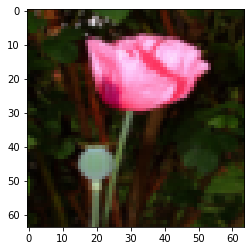

In [10]:
#checking a random image
plt.imshow(train_set_x_orig[30])

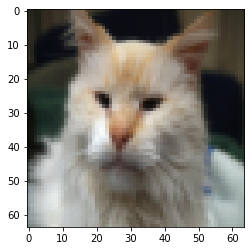

In [9]:
plt.imshow(train_set_x_orig[27])

In [12]:
#Finding information about the number of training samples, number of testing samples and image size

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))

#Square images so image size is num_px * num_px * 3 (rgb)
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [15]:
#converting the images into a single flattened input vector
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print(train_set_x_flatten.shape)
print(test_set_x_flatten.shape)

(12288, 209)
(12288, 50)


In [16]:
#We need to standardise the images so that the value is 0-255
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [17]:
#Defining the sigmoid function which we will be using in our logistic regression
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

#Defining a function to initialise the weight vector with 0 values
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.0
    
    return w, b


#Defining a function which will calculate the forward pass and backward pass of the algorithm once
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    #Forward propogation
    A = sigmoid(np.dot(w.T,X)+b)
    cost = (-1/m)*np.sum(np.dot(np.log(A),Y.T)+np.dot(np.log(1-A),1-Y.T))
    
    #backward pass
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)
    
    #cost will be an array which will retain costs of previous cycles as well
    cost = np.squeeze(np.array(cost))
    
    #grads will only be for the current cycle
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [18]:
#Function to actually implement the gradient descent algorithm
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    
    #creating deep copies so that we can update them simultaneously at the end
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        #Applying the forward and backward pass
        grads,cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        #Updating weights using gradient descent
        w = w - (learning_rate * dw)
        b = b - (learning_rate * db)
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [19]:
#Function to predict
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    #calculating the values using dot product
    A = sigmoid(np.dot(w.T,X)+b)
    
    #these values need to be assigned either 0 or 1 since logistic regression does not work on continuous values
    for i in range(A.shape[1]):
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
            
    return Y_prediction

In [20]:
#Building a complete logistic regression model using the above defined functions
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    
    #Initialise the weights
    w,b = initialize_with_zeros(X_train.shape[0])
    
    #Apply gradient descent
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params["w"]
    b = params["b"]
    
    #Get predictions for both train and test
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [21]:
#actually running the aove defined model on our cats dataset
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, 
                                  learning_rate=0.005, print_cost=True)


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


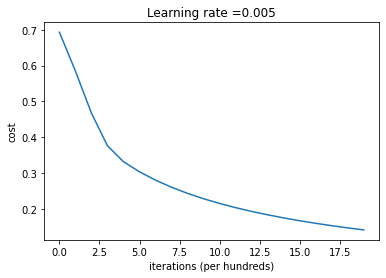

In [22]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

y = 1, Prediction: cat


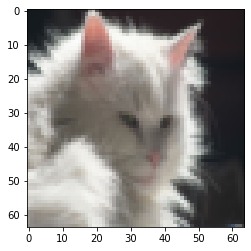

In [25]:
#checking random output
index = 8
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", Prediction: " + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8"))

y = 1, Prediction: non-cat


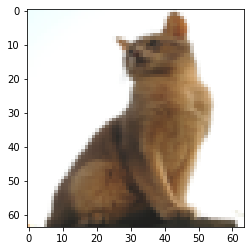

In [27]:
#checking random output
index = 6
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", Prediction: " + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8"))